# **Exploring a Multimodal Nutritional Data Set**

This exercise provides a practical example of how a dataset from a real nutritional study could be analyzed and explored using basic statistical and machine learning techniques.
The primary goal is to identify features that significantly influence an observed nutritional effect within the study.
By applying these techniques, we aim to uncover the key factors that contribute to the outcomes, helping to enhance our understanding of nutritional impacts and guide future research.
Specifically, the small size of the dataset is a challenge here.

The dataset we are analyzing is derived from the 2023 study "[Distinct Microbial Taxa Are Associated with LDL-Cholesterol Reduction after 12 Weeks of Lactobacillus plantarum Intake in Mild Hypercholesterolemia: Results of a Randomized Controlled Study](https://doi.org/10.1007/s12602-023-10191-2)".
The study investigates the effects of probiotic bacteria on individuals with mildly elevated LDL cholesterol levels.
Key data collected includes LDL cholesterol levels before and after the 12-week study period, along with various patient features recorded at the study's onset.

Our analytical goal is to identify which key features might be linked to a significant reduction in LDL cholesterol.
Data from the placebo group or from participants who left the study during execution have already been removed.

## Preprocessing

In [194]:
from typing import Dict

### Identifying correlations in the data

In this section, we start by identifying the features of the multimodal nutritional dataset and determining the number of samples.
Understanding the structure and volume of our dataset is essential for guiding our preprocessing and analysis efforts.

We will analyze how features in our dataset are correlated by generating a heat map.
This color-coded representation will help us identify strong correlations, revealing potential relationships between different features.
Identifying correlated features is crucial because we plan to use a random forest model to infer feature importance.
Highly correlated features can lead to inconsistent results in such models due to redundancy.
To maintain the robustness of our analysis, we will remove or combine features that are highly correlated.

##### ❓ **Q1** &mdash; Pearson correlation coefficients

Calculate the Pearson [correlation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) coefficients for each pair of features and plot them as a [heat map](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [195]:
import pandas as pd
import seaborn as sns


def load_dataset(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(filepath_or_buffer=file_path)
    df.replace(to_replace="NA", value=pd.NA)
    return df


def plot_correlations(dataset: pd.DataFrame, corr_thresh: float) -> None:
    corr_matrix = dataset.corr(method="pearson").abs()
    high_corr_matrix = corr_matrix[corr_matrix > corr_thresh]
    sns.heatmap(data=high_corr_matrix, cmap="coolwarm")

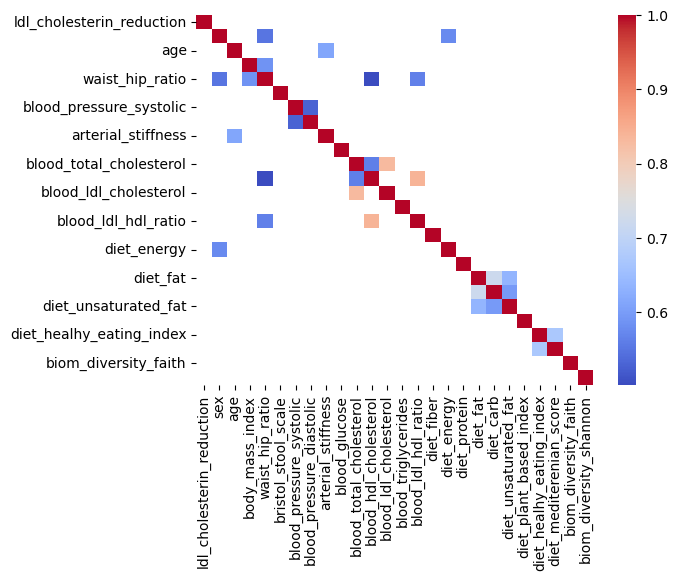

In [196]:
dataset = load_dataset(file_path="responder.csv")
plot_correlations(dataset=dataset, corr_thresh=0.5)

### Data imputation

Handling missing data is a common challenge in dataset preparation, especially when preparing data for training models.
Ideally, we could exclude all samples with missing features to ensure data cleanliness, but this is not feasible due to the already limited size of our dataset.
Removing too many samples could significantly impact the validity and generalizability of our model.

As an alternative, we will employ data imputation to fill in the missing values using the existing data, ensuring minimal distortion of the dataset.
This method allows us to retain as much data as possible while addressing the gaps in information.

There are various techniques for data imputation, but for simplicity and effectiveness, we will use the median value of each feature to replace missing values.
Using the median is robust against outliers and helps maintain the distributional characteristics of the dataset, making it a suitable choice for our purposes.

In [197]:
def count_nans(dataset: pd.DataFrame) -> None:
    # Count the number of NaN values in each column
    nan_counts = dataset.isna().sum()

    # Filter and print the counts where they are not zero
    print("Counts of 'NaN' values in each column where they exist:")
    for column, count in nan_counts.items():
        if count > 0:
            print(f"  {column}: {count}")


def impute_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    return dataset.fillna(dataset.median())

In [198]:
dataset = load_dataset(file_path="responder.csv")
dataset_imputed = impute_dataset(dataset=dataset)

count_nans(dataset=dataset)
count_nans(dataset=dataset_imputed)

Counts of 'NaN' values in each column where they exist:
  body_mass_index: 1
  bristol_stool_scale: 3
  blood_hdl_cholesterol: 1
  blood_ldl_hdl_ratio: 1
Counts of 'NaN' values in each column where they exist:


### Data standardization

The analysis of boxplots has revealed significant variation in the range of values across different features in our dataset.
For instance, the feature representing sex ranges from 0 to 1, while age is predominantly above 60.
These disparities in scale can pose challenges in modeling, as features with larger ranges might disproportionately influence the results.

To address this issue and ensure each feature contributes equally to the analysis, we will standardize the features.
Standardization involves rescaling the data so that each feature has a mean of zero and a standard deviation of approximately one.
This process transforms each feature into a scale where the values represent "more of that feature" or "less of that feature."

By standardizing the features, we eliminate the problem of differing scales and make the dataset more suitable for sophisticated statistical techniques and machine learning models, which often assume data is normally distributed around zero.
This step is crucial for fair comparison and effective integration of features in our analyses.

##### ❓ **Q2** &mdash; Data standardization

Use scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardize the dataset.

In [199]:
from sklearn.preprocessing import StandardScaler


def standardize_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        StandardScaler().fit_transform(X=dataset), columns=dataset.columns
    )

In [200]:
dataset = load_dataset(file_path="responder.csv")
dataset_imputed = impute_dataset(dataset=dataset)
dataset_standardized = standardize_dataset(dataset=dataset_imputed)

To better understand the distribution and range of values for each feature in our dataset, we will utilize boxplots.
Boxplots are an excellent tool for visually summarizing the central tendency, variability, and presence of outliers within each feature.

By analyzing these boxplots, we can quickly gauge the spread of the data, identify any features with extreme values, and determine how these outliers might affect the overall analysis.
This visualization step is crucial for ensuring that we fully comprehend the data's characteristics before proceeding with more complex analyses and modeling.

<Axes: >

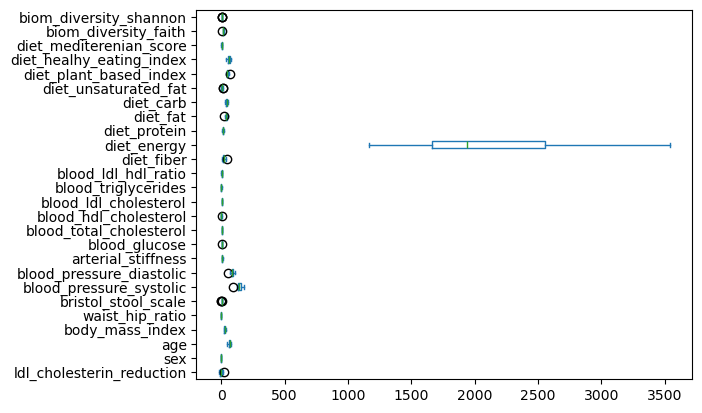

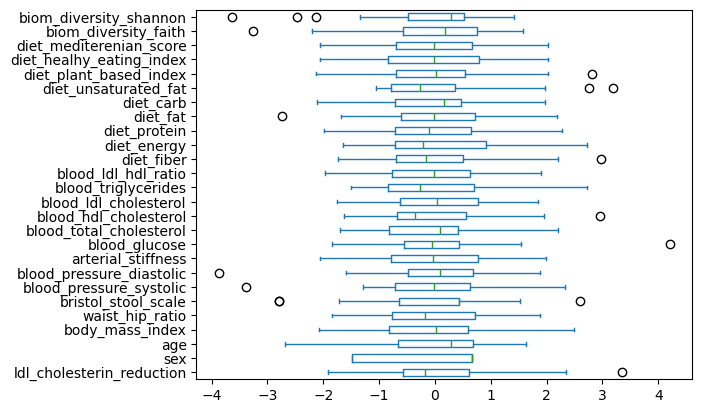

In [201]:
dataset.plot(kind="box", vert=False)
dataset_standardized.plot(kind="box", vert=False)

### Dropping redundant features

As observed from the heat map, our dataset contains several highly correlated features.
Some of these correlations are quite straightforward, such as total cholesterol being correlated with LDL and HDL cholesterol levels.
Others, while less direct, are still plausible; for example, arterial stiffness shows a correlation with age, and dietary energy intake varies significantly with sex.

Given these observations, our next step in preprocessing is to streamline the dataset by removing redundant features.
By eliminating features that are already expressed through others, we can simplify the model's complexity without losing crucial information.
This reduction not only enhances the performance of our future analyses but also helps in achieving more accurate and interpretable results from the random forest model.

In [202]:
def remove_redundant_features(
    dataset: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    labels = dataset.ldl_cholesterin_reduction

    redundant_features = [
        "arterial_stiffness",
        "waist_hip_ratio",
        "diet_energy",
        "diet_mediterenian_score",
        "blood_pressure_systolic",
        "diet_carb",
        "diet_unsaturated_fat",
        "blood_ldl_cholesterol",
        "blood_hdl_cholesterol",
        "ldl_cholesterin_reduction",  # Remove label to prevent data leakage
    ]

    dataset_wo_redundancy = dataset.drop(labels=redundant_features, axis=1)

    return labels, dataset_wo_redundancy

In [203]:
def preprocess_dataset(dataset: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    dataset_imputed = impute_dataset(dataset=dataset)
    dataset_standardized = standardize_dataset(dataset=dataset_imputed)
    labels, dataset_wo_redundancy = remove_redundant_features(
        dataset=dataset_standardized
    )
    return labels, dataset_wo_redundancy

<Axes: >

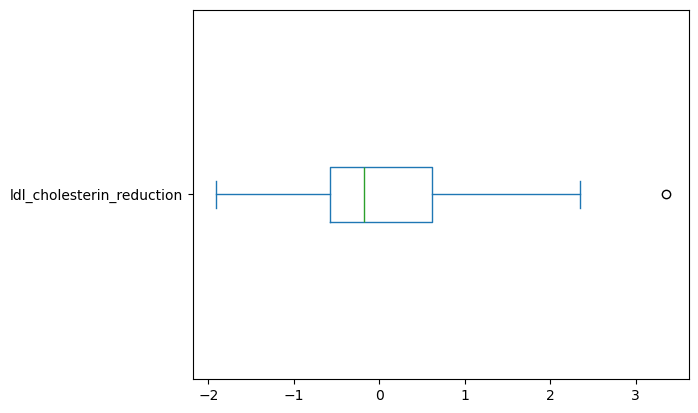

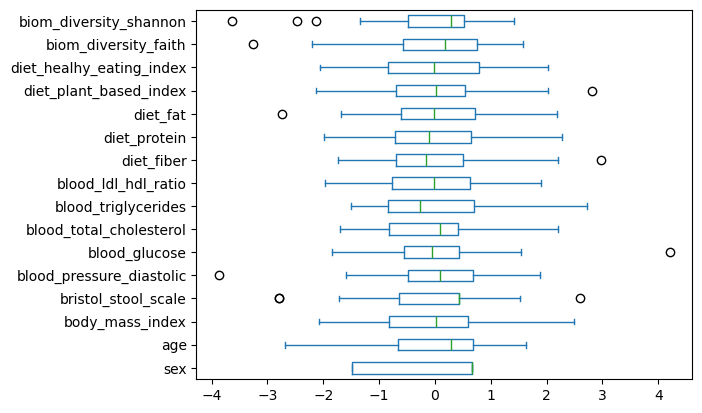

In [204]:
dataset = load_dataset(file_path="responder.csv")
labels, dataset_preprocessed = preprocess_dataset(dataset=dataset)

labels.plot(kind="box", vert=False)
dataset_preprocessed.plot(kind="box", vert=False)

## Random forest model & feature importance

### Decision trees

A decision tree is a machine learning model that uses a series of decisions to split data into branches and leaves.
At each node of the tree, a decision is made based on a feature, directing the data down the appropriate branch until a prediction is made at a leaf node.

This model is straightforward and mimics human decision-making, making it easy to understand and interpret.
However, decision trees can overfit if they grow too deep or complex, meaning they may not generalize well to new data.
They are versatile for both classification and regression tasks but are often used within ensemble methods like random forest to enhance their accuracy and robustness.

### Random forests

A random forest is an ensemble machine learning method that improves upon the simplicity of decision trees by creating a "forest" of them and aggregating their outputs.
This model works by constructing multiple decision trees during training, each on a slightly different subset of the data and features.
This technique, known as bootstrap aggregating or "bagging," helps in reducing the model's variance.

When making predictions, a random forest takes the outputs from all the individual trees and combines them to produce a more accurate and stable prediction.
For classification tasks, this typically means taking a majority vote among the predictions from all trees.
For regression tasks, it usually involves averaging the outputs.

The strength of a random forest lies in its ability to perform well on complex datasets with minimal tuning while avoiding overfitting, a common problem with individual decision trees.
This robustness, combined with its straightforward interpretability (where the importance of features can be easily evaluated), make random forest models a popular choice for many predictive modeling tasks.

<img src="Random_forest_explain.png" width="800" />

### Feature importance

Feature importance in a random forest provides insights into which features are most influential in making predictions.
This method evaluates the impact of each feature on the accuracy of the model by observing how random alterations to feature values affect the model's performance.

In a random forest, feature importance is typically measured by the average decrease in impurity (such as Gini impurity or entropy) across all trees in the forest when a feature is used to split the data.
Alternatively, it can be assessed by examining the increase in prediction error when values of a feature are permuted, which disrupts the relationship between the feature and the target.

This approach helps in identifying features that contribute significantly to the decision-making process of the model, allowing for better understanding and optimization of the model.
Feature importance is valuable for feature selection, providing a way to remove irrelevant or less important features and potentially improve model performance.

## Building a model to predict LDL cholesterol reduction

To develop a predictive model for LDL cholesterol reduction based on our nutritional study data, we will follow several key steps:

1. **Splitting the dataset into training and test sets**:
Before training our model, we must split the dataset into a training set and a test set.
The training set is used to train the model, allowing it to learn from the data.
The test set, however, serves an unbiased role in evaluating the performance of the model.
This separation helps in detecting overfitting and assessing the generalizability of the model to new, unseen data.
*It is crucial to apply preprocessing steps to the training and test sets independently*.
This approach prevents data leakage, where information from the test set inadvertently influences the model training process.

2. **Training the random forest classifier**:
With our data divided and preprocessed, we will proceed to train a random forest classifier.
This model will use the training set to learn the patterns that correlate various dietary and health-related features with reductions in LDL cholesterol.
After training, we will assess the performance of the model by calculating the loss on both the training set and the test set.
This evaluation helps us understand how well the model has learned from the training data and how it performs on unseen data.

3. **Extracting feature importance**
Finally, we will extract the feature importances determined by the random forest.
These importances reveal which features have the most influence on predicting LDL cholesterol reduction.
We will visualize these importances using a plot to easily identify the most significant features according to the model.
This insight is valuable for understanding the driving factors behind LDL vcholesterol reduction and could inform further research and decision-making.

In random forest models, adjusting tree parameters like tree depth and the number of trees is essential for balancing learning depth and prediction stability.
Deeper trees can learn more complex patterns, but may overfit, especially with small datasets.
More trees improve prediction stability but increase computational load.
With our small dataset, preventing overfitting solely through these adjustments is challenging and the feature importance through subsequence runs not very stable.

### Training a basic random forest model

##### ❓ **Q3** &mdash; Training a random forest

There are two lines missing from the code below.
Complete the code to train the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and to compute the [validation loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [205]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def random_forest_fit_predict(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    n_estimators: int,
    max_depth: int,
) -> tuple[float, float, pd.DataFrame]:
    # Random forest training
    random_forest = RandomForestRegressor(
        n_estimators=n_estimators, max_depth=max_depth
    )
    random_forest.fit(X=X_train, y=y_train)

    # Training and validation loss
    training_loss = random_forest.score(X=X_train, y=y_train)
    validation_loss = mean_squared_error(
        y_true=y_test, y_pred=random_forest.predict(X=X_test)
    )

    # Feature importances
    feature_importances = pd.DataFrame(
        data={"feature_importance": random_forest.feature_importances_},
        index=X_train.columns,
    )

    return training_loss, validation_loss, feature_importances

In [206]:
def plot_feature_importances(feature_importances: pd.DataFrame) -> None:
    sorted_feature_importances = feature_importances.sort_values(
        by="feature_importance", ascending=False
    )
    sorted_feature_importances.plot(kind="bar")

Training loss: 0.39512419838052315
Validation loss: 1.774206552053006


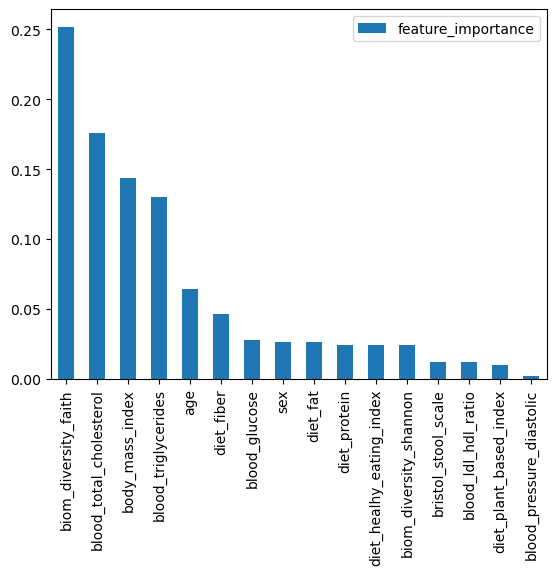

In [207]:
from sklearn.model_selection import train_test_split


dataset = load_dataset(file_path="responder.csv")
labels, dataset_preprocessed = preprocess_dataset(dataset=dataset)

X_train, X_test, y_train, y_test = train_test_split(
    dataset_preprocessed, labels, test_size=0.2
)

training_loss, validation_loss, feature_importances = random_forest_fit_predict(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    n_estimators=500,
    max_depth=1,
)

print(f"Training loss: {training_loss}")
print(f"Validation loss: {validation_loss}")
plot_feature_importances(feature_importances=feature_importances)

### Stabilizing model predictions and feature importance through a larger ensemble

To improve the stability of our random forest model predictions and feature importance assessments, we average results over multiple training iterations.
This method reduces the influence of any specific dataset anomalies by training the model several times with varying data subsets or initial conditions. 

The averaging over the feature importance of multiple trainings can be considered an ensemble prediction of feature importance, just like the random forest is an ensemble prediction of the label.

Note: Specifically for random forests, a similar effect could be achieved by increasing the number of trees in the forest.
However, other model architectures which do not have a "forest" can be used with the following approach as well.

In [208]:
import numpy as np


def avg_random_forest_fit_predict(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    n_estimators: int,
    max_depth: int,
    n_iterations: int,
) -> tuple[float, float, pd.DataFrame]:
    total_training_loss = 0
    total_validation_loss = 0
    total_feature_importances = np.zeros(X_train.shape[1])

    for _ in range(n_iterations):
        training_loss, validation_loss, feature_importances = random_forest_fit_predict(
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            n_estimators=n_estimators,
            max_depth=max_depth,
        )

        total_training_loss += training_loss
        total_validation_loss += validation_loss
        total_feature_importances += feature_importances["feature_importance"].to_list()

    avg_training_loss = total_training_loss / n_iterations
    avg_validation_loss = total_validation_loss / n_iterations
    avg_feature_importances = total_feature_importances / n_iterations

    return (
        avg_training_loss,
        avg_validation_loss,
        pd.DataFrame(
            data={"feature_importance": avg_feature_importances},
            index=X_train.columns,
        ),
    )

Training loss: 0.4364689304334797
Validation loss: 1.6135449655856102


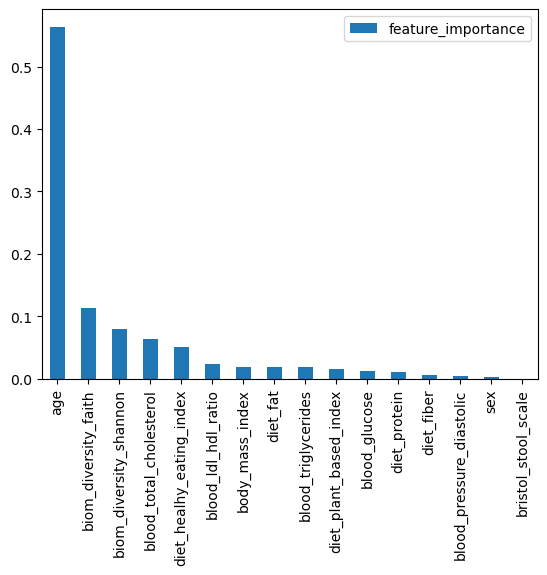

In [209]:
dataset = load_dataset(file_path="responder.csv")
labels, dataset_preprocessed = preprocess_dataset(dataset=dataset)

X_train, X_test, y_train, y_test = train_test_split(
    dataset_preprocessed, labels, test_size=0.2
)

training_loss, validation_loss, feature_importances = avg_random_forest_fit_predict(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    n_estimators=50,
    max_depth=1,
    n_iterations=10,
)

print(f"Training loss: {training_loss}")
print(f"Validation loss: {validation_loss}")
plot_feature_importances(feature_importances=feature_importances)

### Stabilizing feature importance through multiple data splits

To further enhance the stability of feature importance assessments, we average the importance scores across multiple training and testing splits.
This method minimizes the impact of variations from any single dataset configuration, ensuring a more consistent and dependable evaluation of which features most significantly influence the model's predictions.
This is especially important on small datasets, as small differences in splits can significantly change the distribution.

Note: While this does not improve the predictions of the model, it can greatly improve our "meta knowledge" about the model and training, e.g., the average amount of overfitting or the average feature importance.

In [210]:
def multisplit_avg_random_forest_fit_predict(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    n_estimators: int,
    max_depth: int,
    n_forest_iterations: int,
    n_dataset_iterations: int,
) -> tuple[float, float, pd.DataFrame]:
    total_training_loss = 0
    total_validation_loss = 0
    total_feature_importances = np.zeros(X_train.shape[1])

    for _ in range(n_dataset_iterations):
        X_train_local, X_val_local, y_train_local, y_val_local = train_test_split(
            X_train, y_train, test_size=0.2
        )

        training_loss, validation_loss, feature_importances = (
            avg_random_forest_fit_predict(
                X_train=X_train_local,
                X_test=X_val_local,
                y_train=y_train_local,
                y_test=y_val_local,
                n_estimators=n_estimators,
                max_depth=max_depth,
                n_iterations=n_forest_iterations,
            )
        )

        total_training_loss += training_loss
        total_validation_loss += validation_loss
        total_feature_importances += feature_importances["feature_importance"].to_list()

    avg_training_loss = total_training_loss / n_dataset_iterations
    avg_validation_loss = total_validation_loss / n_dataset_iterations
    avg_feature_importances = total_feature_importances / n_dataset_iterations

    return (
        avg_training_loss,
        avg_validation_loss,
        pd.DataFrame(
            data={"feature_importance": avg_feature_importances},
            index=X_train.columns,
        ),
    )

Training loss: 0.4189205063383866
Validation loss: 0.862642598577005


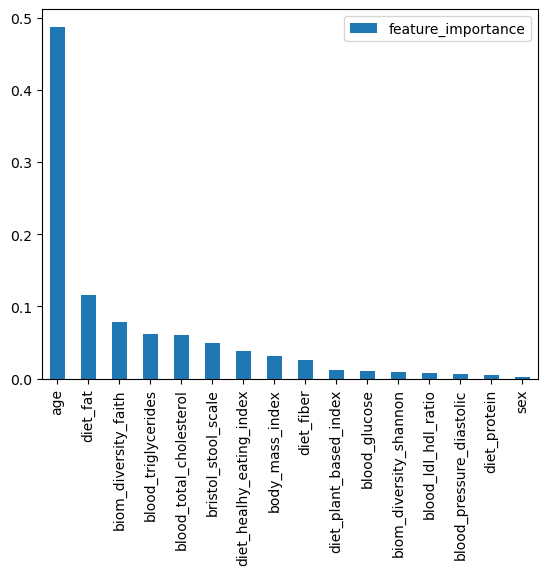

In [211]:
dataset = load_dataset(file_path="responder.csv")
labels, dataset_preprocessed = preprocess_dataset(dataset=dataset)

X_train, X_test, y_train, y_test = train_test_split(
    dataset_preprocessed, labels, test_size=0.2
)

training_loss, validation_loss, feature_importances = (
    multisplit_avg_random_forest_fit_predict(
        X_train=X_train,
        y_train=y_train,
        n_estimators=50,
        max_depth=1,
        n_forest_iterations=10,
        n_dataset_iterations=10,
    )
)

print(f"Training loss: {training_loss}")
print(f"Validation loss: {validation_loss}")
plot_feature_importances(feature_importances=feature_importances)

### Iteratively dropping least significant features

In this experiment, we systematically drop the least significant features from our model based on their importance scores to evaluate the impact on model performance. Starting with all features, we train the model, assess feature importance, and then remove the feature with the lowest importance score. This process is repeated, each time training the model with one fewer feature. This helps to establish a rank between the features. In the case of a usable model prediction, a sudden drop in model performance can also indicate an optimal number of features.

In [212]:
def drop_feature_experiment():
    dataset = load_dataset(file_path="responder.csv")
    labels, dataset_preprocessed = preprocess_dataset(dataset=dataset)

    X_train, X_test, y_train, y_test = train_test_split(
        dataset_preprocessed, labels, test_size=0.2
    )

    results = []
    feature_names = X_train.columns.tolist()
    feature_drop_iterations = {feature: [] for feature in X_train.columns}

    while len(feature_names) >= 1:
        training_loss, validation_loss, feature_importances = (
            multisplit_avg_random_forest_fit_predict(
                X_train=X_train[feature_names],
                y_train=y_train,
                n_estimators=20,
                max_depth=1,
                n_forest_iterations=5,
                n_dataset_iterations=5,
            )
        )

        results.append((training_loss, validation_loss, feature_names))

        # Drop the feature with the lowest importance
        least_important_feature = feature_names[np.argmin(feature_importances)]
        feature_names.remove(least_important_feature)
        feature_drop_iterations[least_important_feature].append(len(feature_names))

        print(
            f"Features left: {len(feature_names):2}. "
            f"Training loss: {training_loss:.6f}. "
            f"Validation loss: {validation_loss:.6f}. "
            f"Feature eliminated: {least_important_feature}."
        )

    return feature_drop_iterations

In [213]:
drop_feature_experiment()

Features left: 15. Training loss: 0.402225. Validation loss: 1.099666. Feature eliminated: blood_pressure_diastolic.
Features left: 14. Training loss: 0.426802. Validation loss: 0.842458. Feature eliminated: blood_glucose.
Features left: 13. Training loss: 0.371200. Validation loss: 1.272995. Feature eliminated: sex.
Features left: 12. Training loss: 0.426046. Validation loss: 1.166519. Feature eliminated: bristol_stool_scale.
Features left: 11. Training loss: 0.403069. Validation loss: 1.248009. Feature eliminated: diet_protein.
Features left: 10. Training loss: 0.376447. Validation loss: 0.925774. Feature eliminated: diet_fiber.
Features left:  9. Training loss: 0.387358. Validation loss: 0.721872. Feature eliminated: blood_ldl_hdl_ratio.
Features left:  8. Training loss: 0.365158. Validation loss: 0.920180. Feature eliminated: age.
Features left:  7. Training loss: 0.358547. Validation loss: 1.113338. Feature eliminated: diet_plant_based_index.
Features left:  6. Training loss: 0.39

{'sex': [13],
 'age': [8],
 'body_mass_index': [2],
 'bristol_stool_scale': [12],
 'blood_pressure_diastolic': [15],
 'blood_glucose': [14],
 'blood_total_cholesterol': [0],
 'blood_triglycerides': [5],
 'blood_ldl_hdl_ratio': [9],
 'diet_fiber': [10],
 'diet_protein': [11],
 'diet_fat': [4],
 'diet_plant_based_index': [7],
 'diet_healhy_eating_index': [3],
 'biom_diversity_faith': [1],
 'biom_diversity_shannon': [6]}

### Average feature rankings

By repeatedly executing the experiment of dropping the least significant features and averaging their ranks across multiple iterations, we can establish a stable ranking of feature importance.
This method involves training the model multiple times, each time removing a feature based on its assessed importance from the previous iteration and recording the rank at which each feature is dropped.

To visualize the stability and variability of these rankings, we can use box plots.
Each feature's rank across different iterations is represented in a box plot, showing the median rank, the interquartile range, and any outliers.
This visualization helps us understand how consistently a feature is valued across multiple models and indicates the robustness of each feature's ranking.

In [214]:
def avg_drop_feature_experiment(n_runs: int) -> Dict:
    # Initialize a dictionary to store iteration counts for each feature
    feature_drop_counts = {}

    # Run the experiment multiple times
    for i in range(n_runs):
        print(f"Experiment {i+1}/{n_runs}")

        curr_feature_drop_iterations = drop_feature_experiment()

        for feature, iteration in curr_feature_drop_iterations.items():
            if feature in feature_drop_counts:
                feature_drop_counts[feature].extend(iteration)
            else:
                feature_drop_counts[feature] = iteration

    return feature_drop_counts

In [215]:
feature_drop_counts = avg_drop_feature_experiment(n_runs=10)

Experiment 1/10
Features left: 15. Training loss: 0.448709. Validation loss: 0.714411. Feature eliminated: blood_glucose.
Features left: 14. Training loss: 0.429062. Validation loss: 0.700755. Feature eliminated: bristol_stool_scale.
Features left: 13. Training loss: 0.462845. Validation loss: 0.609413. Feature eliminated: blood_pressure_diastolic.
Features left: 12. Training loss: 0.435951. Validation loss: 0.879467. Feature eliminated: sex.
Features left: 11. Training loss: 0.428552. Validation loss: 0.857644. Feature eliminated: diet_healhy_eating_index.
Features left: 10. Training loss: 0.437408. Validation loss: 0.471416. Feature eliminated: diet_protein.
Features left:  9. Training loss: 0.400628. Validation loss: 0.936782. Feature eliminated: diet_plant_based_index.
Features left:  8. Training loss: 0.436094. Validation loss: 0.707741. Feature eliminated: blood_ldl_hdl_ratio.
Features left:  7. Training loss: 0.460153. Validation loss: 0.812131. Feature eliminated: biom_diversit

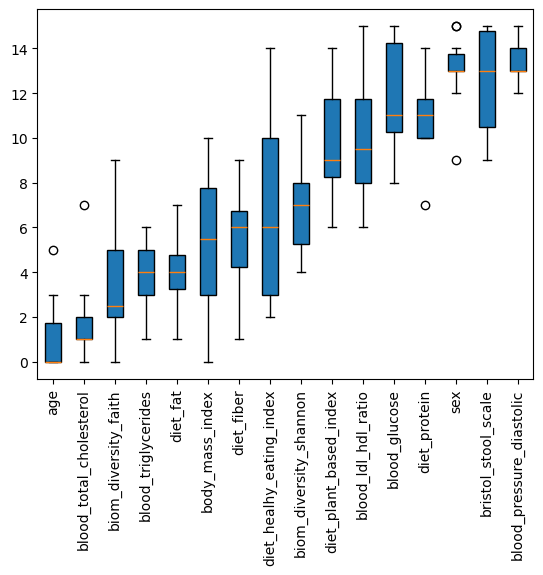

In [216]:
import matplotlib.pyplot as plt


sorted_feature_drop_counts = sorted(
    feature_drop_counts.items(), key=lambda item: np.median(item[1])
)
features_sorted, drop_counts_sorted = zip(*sorted_feature_drop_counts)

plt.boxplot(x=drop_counts_sorted, labels=features_sorted, patch_artist=True)
plt.xticks(rotation=90)
plt.show()